# KNN Shapley

This notebook shows how to calculate Shapley values of the KNN algorithm. Compared to the general Shapley implementation, which has an exponential computation complexity, KNN-Shapley can be computed in linear time, as explained in [this paper](http://www.vldb.org/pvldb/vol12/p1610-jia.pdf). Let's start from importing the main libraries.

In [1]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets
from valuation.utils.plotting import plot_iris

from valuation.shapley.knn import knn_shapley
from valuation.utils import Dataset

/Users/fabio/miniconda3/envs/data_shapley/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Through the Dataset class we can load the iris sklearn dataset. For more info on the data see [the dedicated sklearn page](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html)

In [2]:
sklearn_dataset=datasets.load_iris()
data = Dataset.from_sklearn(sklearn_dataset)

The next cell shows how to calculate the Shapley values using the pyDVL knn_shapley method

In [3]:
knn = KNeighborsClassifier(n_neighbors=5)
shapley_values = knn_shapley(data, knn)
values = np.array([shapley_values[k] for k in shapley_values])

30it [00:00, 4162.67it/s]


Let's now plot the labeles distribution as a function of petal and sepal length

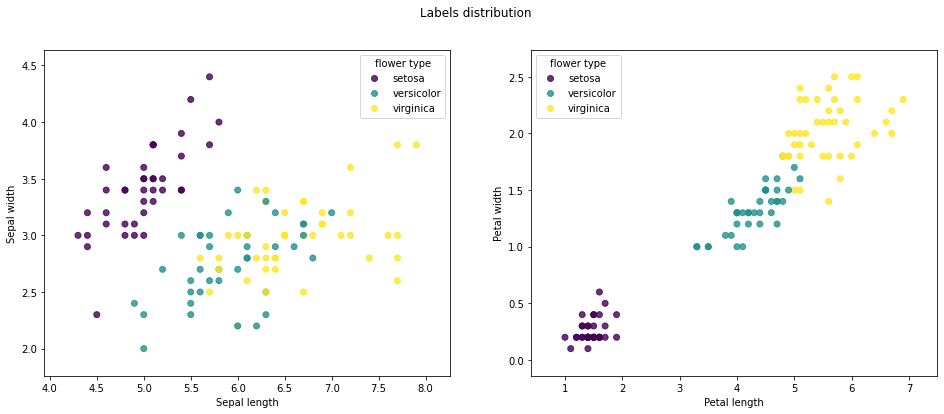

In [4]:
plot_iris(data, legend_title='flower type', legend_labels=list(sklearn_dataset.target_names), suptitle='Labels distribution', colorbar_limits=None)

If we now plot the distribution of Shapley values for each class, we see that each has both high score and low score samples. This is expected, because for training an accurate model we need information on all of the classes.

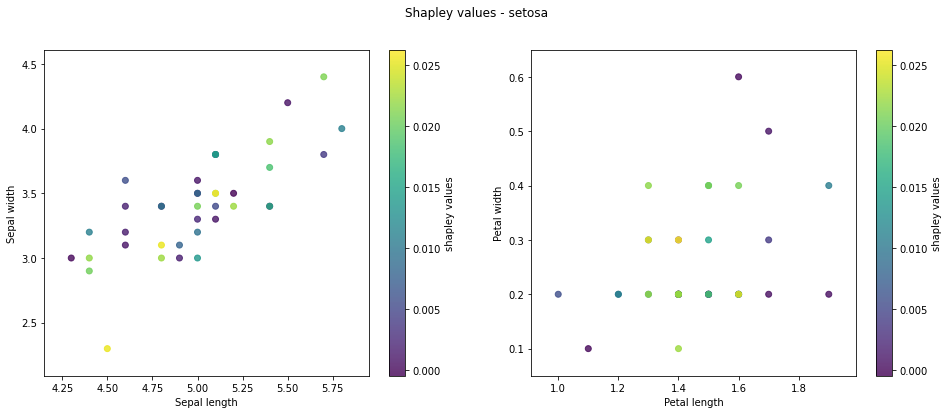

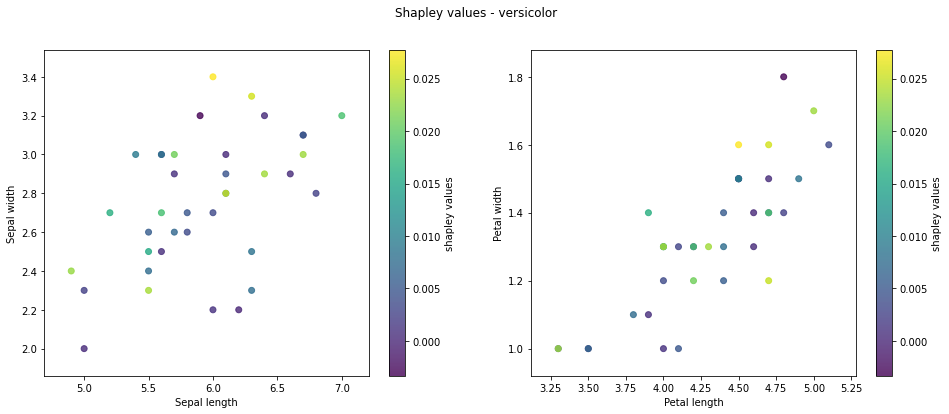

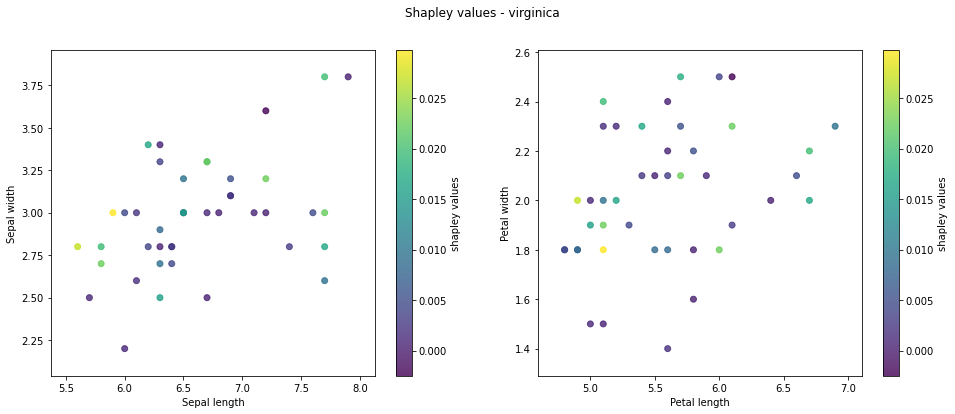

In [5]:
class_ids = np.unique(data.y_train)
for class_id in class_ids:
    class_idxs = np.array([i for i, label in enumerate(data.y_train) if label == class_id])
    plot_iris(data, indices=class_idxs, colors=values[class_idxs], legend_title='shapley values', suptitle=f'Shapley values - {sklearn_dataset.target_names[class_id]}')

## Corrupting labels

As done in the notebook for general Shapley, we can corrupt some of the train labels and see how their Shapley values change with respect to the non-corrupted points. 

In [6]:
from copy import deepcopy
corrupted_dataset = deepcopy(data)
corrupted_dataset.y_train[:10] = [(value + 1)%3 for value in corrupted_dataset.y_train[:10]]
knn = KNeighborsClassifier(n_neighbors=5)
contaminated_shapley = knn_shapley(corrupted_dataset, knn)

30it [00:00, 3860.03it/s]


Taking the average corrupted value and comparing it to non-corrupted ones, we notice that on average anomalous points have a much lower score, i.e. they tend to be much less valuable to the model.

In [7]:
corrupted_shapley_values = [contaminated_shapley[idx] for idx in range(10)]
print("Mean shapley value of corrupted points:", np.mean(corrupted_shapley_values))

Mean shapley value of corrupted points: -0.004094430756052046


In [8]:
correct_shapley_values = [contaminated_shapley[idx] for idx in range(10, len(contaminated_shapley))]
print("Mean shapley value of regular points:", np.mean(correct_shapley_values))

Mean shapley value of regular points: 0.010998146753005948


This is confirmed if we plot the Shapley values distribution

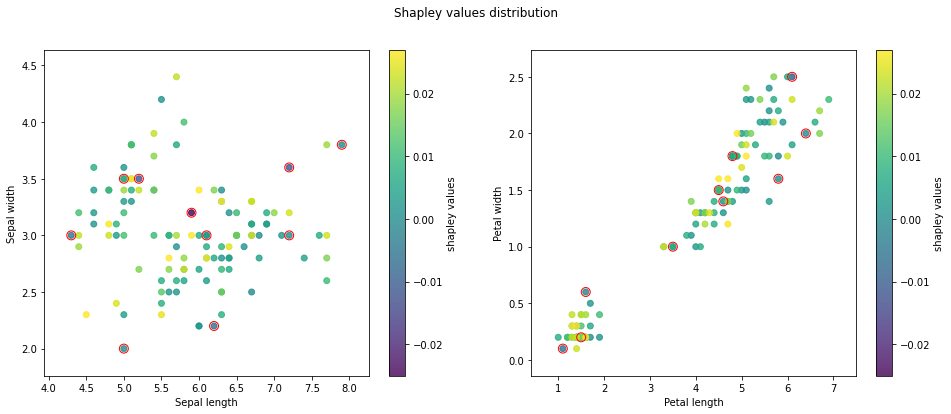

In [21]:
values = np.array([contaminated_shapley[k] for k in contaminated_shapley])
plot_iris(data, colors=values, corrupted_indices=np.array(range(10)), legend_title='shapley values', suptitle='Shapley values distribution', colorbar_limits=(-0.025,0.027))

In the above plot, corrupted points are circled in red. They all tend to have low Shapley scores, regardless of their position in space and assigned label. 